In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import six


sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})


import anchor


from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR, MODALITY_TO_CMAP

%load_ext autoreload
%autoreload 2

# Figures in the notebook
%matplotlib inline

# Set random seed
np.random.seed(sum(map(ord, 'anchor')))



# Define folder to save figures
folder = 'figures/bimodality_index'
!mkdir -p $folder


/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


In [2]:
dataset_name_to_folder = {'Perfect Modalities': '../S05._Supplementary_Figure5',
                         # 'Maybe Bimodals': '../S06._Supplementary_Figure6'
                         }

datatypes = 'data', 'metadata'
datasets = {name: {datatype: pd.read_csv('{}/{}.csv'.format(folder, datatype), index_col=0) 
              for datatype in datatypes} for name, folder in dataset_name_to_folder.items()}


In [3]:
def name_to_filename(name):
    return name.lower().replace(' ', '_')

for name in datasets:
    dataset_folder = '{}/{}'.format(folder, name_to_filename(name))
    ! mkdir $dataset_folder

In [4]:
from sklearn.mixture import GMM

for name, datas in datasets.items():
    six.print_(name)
    data = datas['data']
    metadata = datas['metadata']
    six.print_(data.shape, metadata.shape)

Perfect Modalities
(100, 8004) (8004, 5)


Perfect Modalities


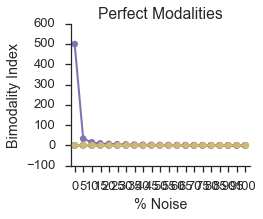

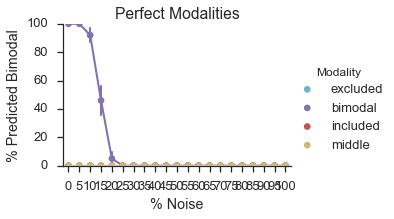

In [5]:
from sklearn.mixture import GMM

for name, datas in datasets.items():
    six.print_(name)
    data = datas['data']
    metadata = datas['metadata']
    
    dataset_folder = '{}/{}'.format(folder, name_to_filename(name))
    gmm = GMM(n_components=2)
    gmm.fit(data)
    means = pd.DataFrame(gmm.means_, columns=data.columns)
    means.head()

    covars = pd.DataFrame(gmm.covars_, columns=data.columns)
    covars.head()

    weights = pd.Series(gmm.weights_)
    weights.head()

    proportions = weights.mean()
    standardized_distance = np.abs(means.loc[0] - means.loc[1])/covars.mean()

    bimodality_index = np.sqrt(proportions * (1-proportions)) * standardized_distance
    bimodality_index.name = "Bimodality Index"
    
    # Add annotation of original modality and noise percentages
    bimodality_index = metadata.join(bimodality_index)
    
    # Add column for when this method predicted bimodality
    bimodality_index['Predicted Bimodal'] = bimodality_index['Bimodality Index'] > 10

    if name == 'Perfect Modalities':
        g = sns.factorplot(x='% Noise', 
                       y='Bimodality Index', 
                   hue='Modality', 
                   data=bimodality_index, kind='point', #col_wrap=2, 
                   hue_order=MODALITY_ORDER, size=3, scale=0.5, dodge=True,
                   palette=MODALITY_PALETTE, aspect=1.25, legend=False)
        g.set(title=name)
        g.savefig('{}/bimodality_index_with_noise.pdf'.format(dataset_folder))

        g = sns.factorplot(x='% Noise', y='Predicted Bimodal', data=bimodality_index, 
                       scale=0.5, size=3, aspect=1.5, hue='Modality', 
                       palette=MODALITY_PALETTE[:-1], hue_order=MODALITY_ORDER[:-1])
        g.set(title=name)
        for ax in g.axes.flat:
            ax.set(ylim=(0, 1), ylabel='% Predicted Bimodal')
            ax.set(yticklabels=[int(100*tick) for tick in ax.get_yticks()])

        g.savefig('{}/bimodality_index_predicted_bimodal.pdf'.format(dataset_folder))
    else:
        g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
               data=bimodality_index, scale=0.5, color='#262626',
               aspect=1.5, ci=None)
        for ax in g.axes.flat:
            ymin, ymax = ax.get_ylim()
            ax.vlines([10, 90], ymin, ymax, linestyle='--')
        g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100), ylim=(ymin, ymax))
        g.savefig('{}_bimodals_percent_predicted_bimodal.pdf'.format(dataset_folder))

        g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
                       data=bimodality_index, scale=0.5, dodge=False,
                       aspect=1.5, ci=None, hue='% Noise', palette='GnBu_r', hue_order=np.arange(0, 101, 5)[::-1])
        g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
        # g.map_dataframe(sns.pointplot,  x='% 1s', y='Predicted Bimodal', scale=0.5, ci=None, dodge=False)
        g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

        g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
                       data=bimodality_index, scale=0.5, dodge=False, legend=False,
                       aspect=1.5, ci=None, color='#262626')
        # g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
        g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

        g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
                       data=bimodality_index, scale=0.5, dodge=False, legend=False,
                       aspect=1.5, ci=None, hue='% 1s', palette='RdYlBu_r', hue_order=np.arange(1, 100)[::-1])
        # g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
        g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise_per_percent_1.pdf'.format(dataset_folder))